## Libraries

In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

In [3]:
import matplotlib.pyplot as plt
import matplotlib 
import seaborn as sns
sns.set(style='darkgrid')

In [4]:
from tqdm import tqdm

In [5]:
import tensorflow as tf

## Read data & preprocessing

In [6]:
# read training data
df_X = pd.read_csv('./data/X_train.csv')
df_y = pd.read_csv('./data/y_train.csv')

In [7]:
# convert into np array, check shape
X_raw = np.array(df_X)[:, 1:]
print(X_raw.shape)

y_raw = np.array(df_y, dtype=int)[:, 1]
print(y_raw.shape)

num_samples = X_raw.shape[0]
num_features = X_raw.shape[1]

(5117, 17813)
(5117,)


In [8]:
# data frames no longer needed
del df_X, df_y

In [9]:
# shuffle the dataset
X_raw, y_raw = shuffle(X_raw, y_raw)

In [10]:
# recordings trimmed of NaNs
recordings = []
for i in range(X_raw.shape[0]):
    recordings.append(X_raw[i, ~np.isnan(X_raw[i,:])])

print(recordings[0])

[  28.   25.   21. ... -142. -157. -164.]


In [ ]:
# dataset augmented by repetition
def augmentation(X):
    augmented = np.copy(X)
    for i in range(X.shape[0]):
        n = 17813
        for j in range(X.shape[1]):
            if np.isnan(X[i,j]):
                n = j
                break
        for j in range(n, X.shape[1]):
            augmented[i,j] = X[i, j%n]
        
    return augmented

X_augmented = augmentation(X_raw)

# make sure no more NaN exists
np.sum(np.isnan(X_augmented))

In [ ]:
X_train = X_augmented[0:5000, :]
X_validation = X_augmented[5000:, :]
y_train = y_raw[0:5000]
y_validation = y_raw[5000:]

In [ ]:
# check group balance
print(np.sum(y_train == 0), np.sum(y_train == 1), np.sum(y_train == 2), np.sum(y_train == 3))
print(np.sum(y_validation == 0), np.sum(y_validation == 1), np.sum(y_validation == 2), np.sum(y_validation == 3))

In [ ]:
# dynamic time warpping -- too slow to be used
def constrained_dtw(t1, t2, w=float('inf'), matrix=False):
    n1 = len(t1)
    n2 = len(t2)
    if w < abs(n1 - n2):
        print('ERROR: constraint smaller than difference in length.')
        exit(1)
    
    # distance matrix with infinity for all entries
    dist_matrix = np.ones((n1+1, n2+1)) * float('inf')
    dist_matrix[0,0] = 0
    
    # distance within the contrained range
    for i in range(n1):
        for j in range(n2): 
            if abs(i-j) <= w:
                dist_matrix[i+1,j+1] = abs(t1[i] - t2[j]) + min(dist_matrix[i,j], dist_matrix[i+1,j], dist_matrix[i,j+1])
    
    if matrix: 
        return dist_matrix
    else:
        return dist_matrix[n1,n2]

In [ ]:
a = np.array([np.sin(x*0.5) for x in range(100)])
#plt.plot(a)
plt.plot(np.fft.rfft(a))

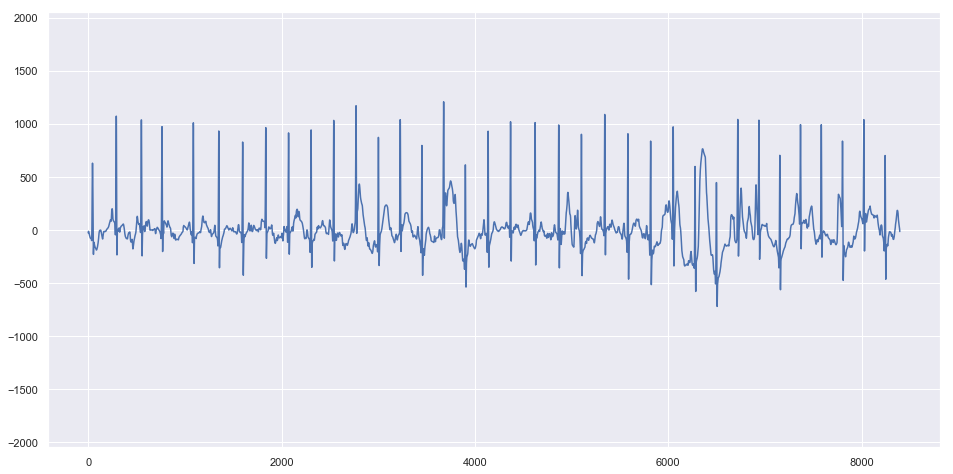

NameError: name 'y_train' is not defined

In [11]:
plt.figure(figsize=(16,8))
plt.ylim(-2048, 2048)

n1 = 3364
plt.plot(recordings[n1])
plt.show()
print('class:', y_train[n1])
print('mean:', np.mean(recordings[n1]))
print('variance:', np.var(recordings[n1]))

plt.figure(figsize=(16,8))
plt.ylim(-2048, 2048)

n2 = 27
plt.plot(X_augmented[n2,:])
plt.show()
print('class:', y_train[n2])
print('mean:', np.mean(recordings[n2]))
print('variance:', np.var(recordings[n2]))

In [ ]:
ecg.hamilton_segmenter(signal=X_augmented[3364], sampling_rate=300)

## Feature Extraction

In [12]:
from biosppy.signals import ecg

In [14]:
# extract R peaks
peaks = []
for i in tqdm(range(len(recordings))): 
    out = ecg.hamilton_segmenter(signal=recordings[i], sampling_rate=300)
    peaks.append(out[0])

  0%|                                                                                         | 0/5117 [00:00<?, ?it/s]c:\python37\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
100%|██████████████████████████████████████████████████████████████████████████████| 5117/5117 [02:11<00:00, 38.80it/s]


In [45]:
# find least number of peaks
least = len(peaks[0])
least_id = 0
most = len(peaks[0])
most_id = 0

for i in range(1,len(peaks)):
    if len(peaks[i]) < least:
        least = len(peaks[i])
        least_id = i
    if len(peaks[i]) > most:
        most = len(peaks[i])
        most_id = i

print(least_id)
print(least)
print(most_id)
print(most)

2347
5
51
158


In [47]:
total = 0
for i in range(len(peaks)):
    total += np.sum(peaks[i] < 50)

print(total)

965


In [23]:
def print_peak(i,j):
    print(np.array([recordings[0][peaks[i][j+1]-50 : peaks[i][j+1]+50]]))

peaks[1454]

array([  40,  229,  467,  680,  924, 1126, 1311, 1504, 1701, 1883, 2074,
       2304, 2510, 2763, 2964, 3152, 3342, 3526, 3710, 3901, 4139, 4342,
       4598, 4800, 4986, 5162, 5356, 5545, 5740, 5977, 6180, 6435, 6636,
       6824, 7016, 7205, 7387, 7575, 7815, 8021, 8278])

In [ ]:
recordings[0][peaks[1][15]-50 : peaks[1][15]+50]

In [37]:
recordings[i][peaks[i][1]-50 : peaks[i][1]+50]

array([], dtype=float64)

In [36]:
# augmentation
X_2d = np.zeros((len(peaks), most-2, 100))
for i in tqdm(range(len(peaks))):
    n = len(peaks[i]) - 2
    for j in range(n):
        X_2d[i, j, :] = recordings[i][peaks[i][j+1]-50 : peaks[i][j+1]+50]
    for j in range(n, most-2):
        X_2d[i, j, :] = X_2d[i, j//n, :]

 30%|██████████████████████▊                                                     | 1539/5117 [00:00<00:01, 2621.03it/s]


ValueError: could not broadcast input array from shape (0) into shape (100)

In [ ]:
test_im = np.array([recordings[0][i-100 : i+100] for i in out[0]])
test_im = test_im / max(np.max(test_im), abs(np.min(test_im)) 

In [ ]:
plt.figure(figsize=(16,4))
plt.imshow(test_im, cmap='gray')

## CNN

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [ ]:
def f1_score(y_true, y_pred):

    # Count positive samples.
    c1 = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    c2 = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    c3 = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    # if c3 == 0:
    #     return 0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score 

In [ ]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Reshape(input_shape=(3000,), target_shape=(3000, 1)),
        
        tf.keras.layers.Conv1D(kernel_size=15, filters=32, activation='relu'),
        
        tf.keras.layers.Conv1D(kernel_size=15, filters=32, activation='relu'),
        
        tf.keras.layers.Conv1D(kernel_size=15, filters=32, activation='relu'),
        
        tf.keras.layers.Conv1D(kernel_size=15, filters=32, activation='relu'),
        tf.keras.layers.GlobalMaxPooling1D(),
        
        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.25),
        
        tf.keras.layers.Dense(4, activation='softmax')
    ]
)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score])
model.summary()

In [ ]:
y_target = tf.keras.utils.to_categorical(y_train)
validation_dataset = (X_validation[:,0:15000:5], tf.keras.utils.to_categorical(y_validation))

model.fit(x=X_train[:,0:15000:5],
          y=y_target,
          batch_size=32, 
          epochs=32, 
          validation_data=validation_dataset)

## Predict

In [ ]:
df_test = pd.read_csv('./data/X_test.csv')
X_test = np.array(df_test)[:,1:]
X_test.shape

In [ ]:
del df_test

In [ ]:
X_test_augmented = augmentation(X_test)

In [ ]:
y_test = model.predict(X_test[:,0:15000:5])
y_test

In [ ]:
result = np.argmax(y_test, axis=1)
result

## Output

In [ ]:
# write output csv
out_df = pd.DataFrame(data={'y': result})
out_df.to_csv('result4.csv', index_label='id')